In [51]:
#This code is experimental. Might need revision.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [52]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [53]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.3]
Best error: 0.06351944278513788


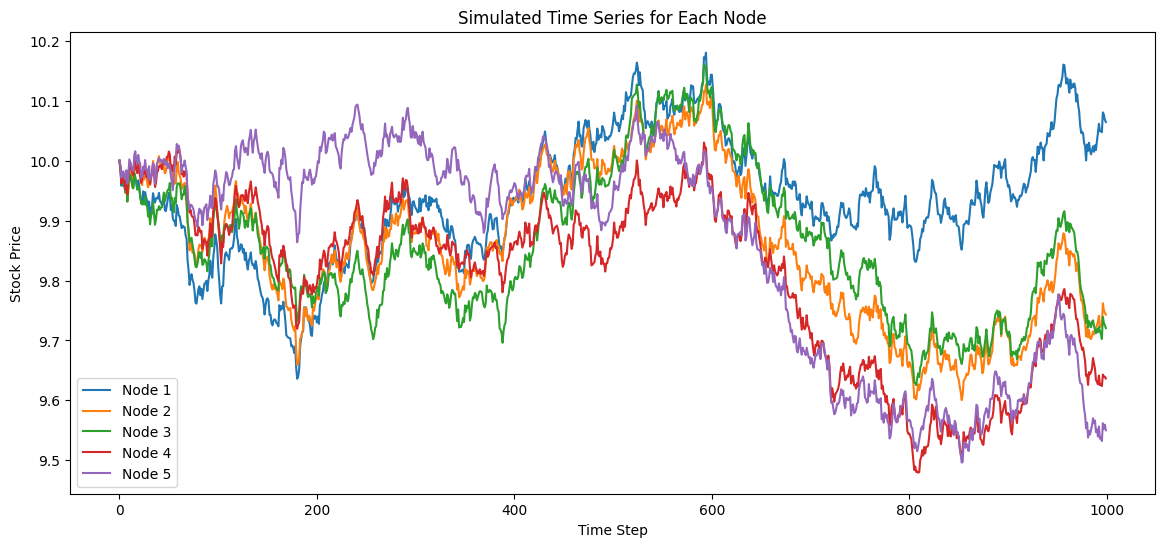

In [54]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

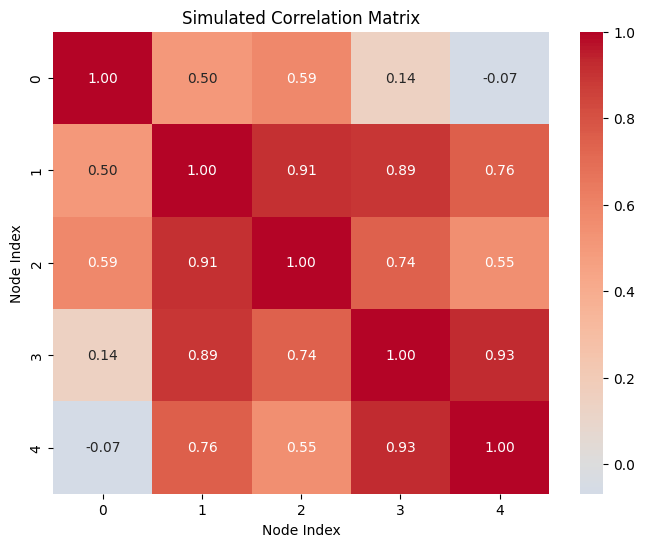

In [55]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [58]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

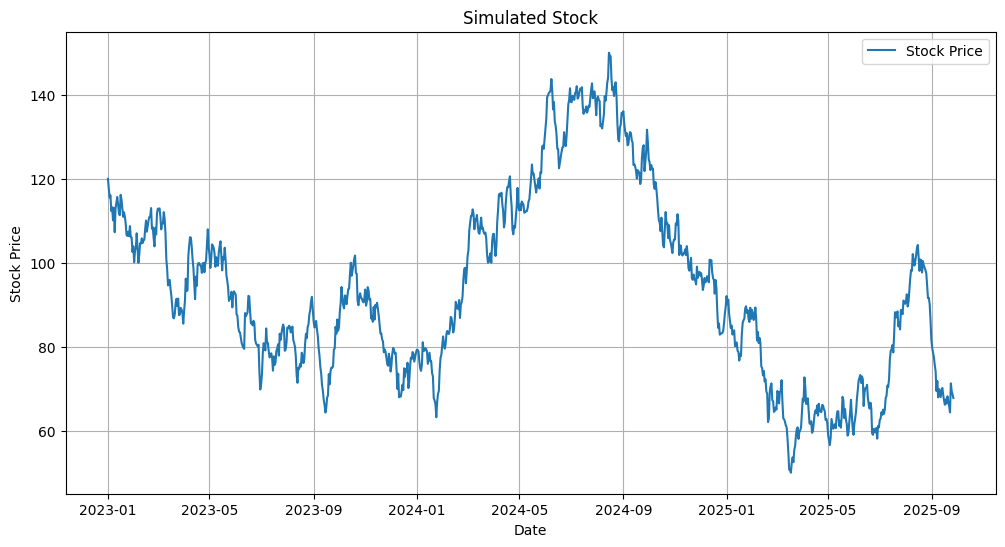

In [59]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
class QLearningMarketMakerAgent:
    """Q-learning agent for market making"""

    def __init__(self, n_time_steps, max_inventory, max_offset, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.1, discount_factor=0.9):
        self.n_time_steps = n_time_steps
        self.max_inventory = max_inventory
        self.max_offset = max_offset
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = learning_rate
        self.gamma = discount_factor

        self.inventory_bins = 2 * max_inventory + 1
        self.action_space = [(b, a) for b in range(-max_offset, max_offset+1) for a in range(-max_offset, max_offset+1)]
        self.action_size = len(self.action_space)
        self.q_table = np.zeros((n_time_steps, self.inventory_bins, self.action_size))

    def discretize_inventory(self, inventory):
        return inventory + self.max_inventory

    def choose_action(self, state):
        t, inventory = state
        inv_bin = self.discretize_inventory(inventory)

        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            return np.argmax(self.q_table[t, inv_bin])

    def update_q_value(self, state, action_idx, reward, next_state):
        t, inventory = state
        next_t, next_inventory = next_state
        inv_bin = self.discretize_inventory(inventory)
        next_inv_bin = self.discretize_inventory(next_inventory)

        best_next_action = np.argmax(self.q_table[next_t, next_inv_bin])
        td_target = reward + self.gamma * self.q_table[next_t, next_inv_bin, best_next_action]
        td_error = td_target - self.q_table[t, inv_bin, action_idx]

        self.q_table[t, inv_bin, action_idx] += self.lr * td_error

    def reset(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)
        print(f"Model loaded from {filename}")

In [62]:
#'df' with a 'StockPrice' column representing mid prices
mid_prices = df['StockPrice'].values  # convert to numpy array

# Initialize the market making trainer
trainer = MarketMakingTrainer(mid_prices, max_inventory=10, max_offset=5, fee=0.0001)

# Train for 50 epochs
trainer.train(epochs=50)

# Evaluate the trained agent
trainer.evaluate()

# Save the trained Q-table
trainer.agent.save_model('market_maker_agent_q_table.pkl')

t=0, inventory=-1, action=(2, 5), reward=119.9286
t=1, inventory=-2, action=(-1, 5), reward=117.8422
t=2, inventory=-3, action=(2, 2), reward=115.4058
t=3, inventory=-3, action=(-5, -5), reward=-0.0900
t=4, inventory=-3, action=(-5, -5), reward=-0.0900
t=5, inventory=-3, action=(-5, -4), reward=-0.0900
t=6, inventory=-3, action=(-5, -4), reward=-0.0900
t=7, inventory=-4, action=(-1, 5), reward=112.9287
t=8, inventory=-5, action=(2, 4), reward=106.9744
t=9, inventory=-5, action=(-5, -5), reward=-0.2500
t=10, inventory=-5, action=(-5, -5), reward=-0.2500
t=11, inventory=-5, action=(-5, -5), reward=-0.2500
t=12, inventory=-5, action=(-5, -5), reward=-0.2500
t=13, inventory=-5, action=(-5, -5), reward=-0.2500
t=14, inventory=-5, action=(-5, -5), reward=-0.2500
t=15, inventory=-5, action=(-5, -5), reward=-0.2500
t=16, inventory=-5, action=(-5, -5), reward=-0.2500
t=17, inventory=-5, action=(-5, -5), reward=-0.2500
t=18, inventory=-5, action=(-5, -5), reward=-0.2500
t=19, inventory=-5, actio